In [1]:
import pandas as pd
import numpy as np

In [2]:
with open("sent_corpus.csv", "r") as sent_file:
    lines = sent_file.read().split("\n")

In [4]:
%time rows = [line.split(",") for line in lines if line]
%time rows = [row[:3] + [",".join(row[3:])] for row in rows]
# remove document start character 
rows[0][0] = rows[0][0][1:]
%time sentDf = pd.DataFrame(rows[1:],columns=rows[0])
sentDf[["ItemID","Sentiment"]] = sentDf[["ItemID","Sentiment"]].astype(int)
%time sentDf["SentimentText"] = sentDf["SentimentText"].apply(lambda text: text.split())

CPU times: user 4.14 s, sys: 699 ms, total: 4.84 s
Wall time: 5.34 s
CPU times: user 3.93 s, sys: 476 ms, total: 4.41 s
Wall time: 4.96 s
CPU times: user 361 ms, sys: 62 ms, total: 423 ms
Wall time: 464 ms
CPU times: user 6.56 s, sys: 2.4 s, total: 8.96 s
Wall time: 9.29 s


In [5]:
import gensim
%time w2vM = gensim.models.Word2Vec(sentDf["SentimentText"])

CPU times: user 6min 31s, sys: 5.41 s, total: 6min 36s
Wall time: 2min 55s


In [6]:
# number of samples to aggregate
Ns = int(1e5)

In [7]:
%%time
# MEAN AGGREGATION
tvecs = np.array([np.array([w2vM[t] if t in w2vM
                                else np.zeros((100,))
                            for t in twt]).mean(axis=0)
                 for twt in sentDf["SentimentText"][:Ns]])
# SUM AGGREGATION
# tvecs = np.array([np.array([w2vM[t] if t in w2vM
#                                 else np.zeros((100,))
#                             for t in twt]).sum(axis=0)
#                  for twt in sentDf["SentimentText"][:Ns]])

CPU times: user 10 s, sys: 475 ms, total: 10.5 s
Wall time: 13 s


In [8]:
# number of samples to train on
N = int(1e5)
X = tvecs[:N]
y = sentDf["Sentiment"][:N].values
# inverse classifier
# y = 1 - y

In [9]:
# generate test/train split
ratio = 0.8
tidx = np.random.rand(N) < ratio
pidx = ~tidx

In [11]:
import sklearn
from sklearn import ensemble,svm,neural_network,discriminant_analysis
from sklearn.metrics import roc_curve,auc,precision_recall_curve

from matplotlib import pyplot as plt
% matplotlib inline

In [12]:
def roc_auc(clf,X,y):
    probs = clf.predict_proba(X[pidx])
    fpr, tpr, thresholds = roc_curve(y[pidx], probs[:, 1])
    roc_auc = auc(fpr, tpr)
    roc_str = 'ROC (AUC Gain = %0.2f)' % (roc_auc - 0.5)
    plt.plot(fpr, tpr, lw=1,label=roc_str)
    plt.plot([0,1],[0,1],label="RAN CLF")
    plt.title(roc_str)
    plt.show()

In [13]:
def prrc_auc(clf,X,y):
    probs = clf.predict_proba(X)
    pr, rc, thresholds = precision_recall_curve(y, probs[:, 1])
    roc_auc = auc(rc, pr)
    roc_str = 'Prec vs Recall (AUC Gain = %0.2f)' % (roc_auc - np.mean(y))
    plt.plot(rc,pr, lw=1,label=roc_str)
    plt.plot([0,1],[np.mean(y),np.mean(y)],label="RAN CLF")
    plt.axis([0,1,0,1])
    plt.title(roc_str)
    plt.show()

In [14]:
def evaluate(clf,X,y):
    yhat = clf.predict(X)
    accu = np.mean(yhat == y)
    prec = np.mean(y[yhat == 1])
    recl = np.mean(yhat[y == 1])
    f1 = 2 * prec * recl / (prec + recl)
    print("Accuracy",accu,"Precision",prec,"Recall",recl,"F1",f1)

CPU times: user 5.87 s, sys: 177 ms, total: 6.05 s
Wall time: 6.84 s
TEST
Accuracy 0.668606675621 Precision 0.659383753501 Recall 0.839664704833 F1 0.73868361183
CPU times: user 44.2 ms, sys: 12.4 ms, total: 56.6 ms
Wall time: 68.5 ms
TRAIN
Accuracy 0.679412243263 Precision 0.670487305061 Recall 0.853253182461 F1 0.750909267723
CPU times: user 133 ms, sys: 28.2 ms, total: 161 ms
Wall time: 169 ms
ROC AUC


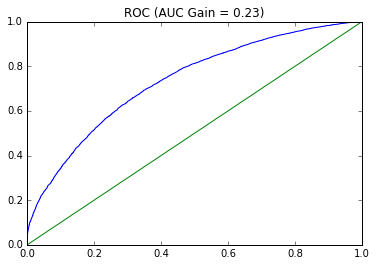

CPU times: user 249 ms, sys: 22.6 ms, total: 272 ms
Wall time: 301 ms
PRECISION/RECALL AUC


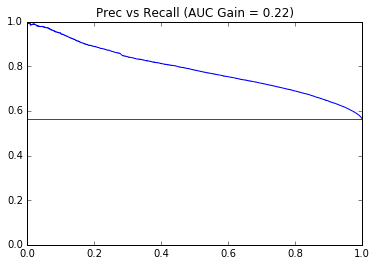

CPU times: user 385 ms, sys: 37.1 ms, total: 422 ms
Wall time: 464 ms


In [15]:
rf = sklearn.ensemble.RandomForestClassifier()
rf.max_depth = 5
clf = rf
%time clf.fit(X[tidx],y[tidx])

print("TEST")
%time evaluate(clf,X[pidx],y[pidx])

print("TRAIN")
%time evaluate(clf,X[tidx],y[tidx])

print("ROC AUC")
%time roc_auc(clf,X,y)

print("PRECISION/RECALL AUC")
%time prrc_auc(clf,X,y)

CPU times: user 1min 5s, sys: 5.6 s, total: 1min 10s
Wall time: 1min 9s
TEST
Accuracy 0.742028552952 Precision 0.765130190007 Recall 0.775637595862 F1 0.77034806483
CPU times: user 72.8 ms, sys: 49 ms, total: 122 ms
Wall time: 116 ms
TRAIN
Accuracy 0.811256993379 Precision 0.828856719281 Recall 0.840213932107 F1 0.834496685544
CPU times: user 267 ms, sys: 132 ms, total: 400 ms
Wall time: 349 ms
ROC AUC


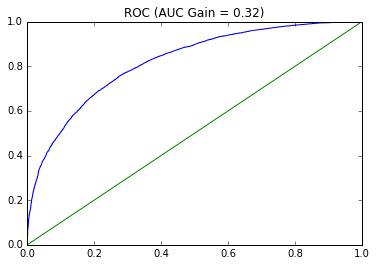

CPU times: user 288 ms, sys: 70.6 ms, total: 359 ms
Wall time: 364 ms
PRECISION/RECALL AUC


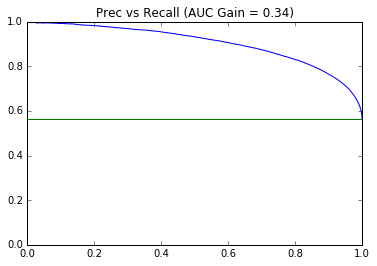

CPU times: user 530 ms, sys: 135 ms, total: 665 ms
Wall time: 666 ms


In [16]:
mlp = sklearn.neural_network.MLPClassifier()
clf = mlp
%time clf.fit(X[tidx],y[tidx])

print("TEST")
%time evaluate(clf,X[pidx],y[pidx])

print("TRAIN")
%time evaluate(clf,X[tidx],y[tidx])

print("ROC AUC")
%time roc_auc(clf,X,y)

print("PRECISION/RECALL AUC")
%time prrc_auc(clf,X,y)

CPU times: user 2.59 s, sys: 219 ms, total: 2.81 s
Wall time: 2.33 s
TEST
Accuracy 0.71173456698 Precision 0.760003838403 Recall 0.706260032103 F1 0.732146984054
CPU times: user 118 ms, sys: 90.6 ms, total: 209 ms
Wall time: 216 ms
TRAIN
Accuracy 0.719376196853 Precision 0.769485042382 Recall 0.720252828854 F1 0.744055433157
CPU times: user 437 ms, sys: 250 ms, total: 687 ms
Wall time: 693 ms
ROC AUC


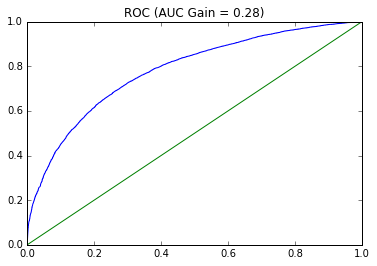

CPU times: user 345 ms, sys: 101 ms, total: 446 ms
Wall time: 469 ms
PRECISION/RECALL AUC


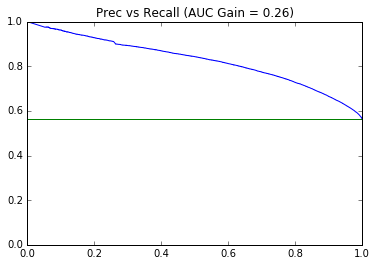

CPU times: user 752 ms, sys: 282 ms, total: 1.03 s
Wall time: 827 ms


In [17]:
qda = sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis()
clf = qda
%time clf.fit(X[tidx],y[tidx])

print("TEST")
%time evaluate(clf,X[pidx],y[pidx])

print("TRAIN")
%time evaluate(clf,X[tidx],y[tidx])

print("ROC AUC")
%time roc_auc(clf,X,y)

print("PRECISION/RECALL AUC")
%time prrc_auc(clf,X,y)